In [1]:
import numpy as np
import pandas as pd
import cv2 as cv
from matplotlib import pyplot as plt
import os
import random
import json
from ultralytics import YOLO
from sahi import AutoDetectionModel
from sahi.predict import get_prediction
from sahi.predict import get_sliced_prediction
import re
from tqdm import tqdm
import torch
from deep_sort_realtime.deepsort_tracker import DeepSort
from collections import Counter
from pathlib import Path

from matplotlib.animation import FuncAnimation
import matplotlib.patches as patches

import plotly.graph_objects as go
import plotly.express as px

from src.mapping_functions import *

In [2]:
# Base path
calib_path = Path("data/Wildtrack/calibrations")

# Load extrinsics
extrinsics = {}
extr_files = ["CVLab1", "CVLab2", "CVLab3", "CVLab4", "IDIAP1", "IDIAP2", "IDIAP3"]

for name in extr_files:
    fs = cv.FileStorage(str(calib_path / "extrinsic" / f"extr_{name}.xml"), cv.FILE_STORAGE_READ)
    rvec_node = fs.getNode('rvec')
    tvec_node = fs.getNode('tvec')
    
    extrinsics[name] = {
        'rvec': np.array([rvec_node.at(i).real() for i in range(int(rvec_node.size()))]),
        'tvec': np.array([tvec_node.at(i).real() for i in range(int(tvec_node.size()))])
    }
    fs.release()

# Load intrinsics
intrinsics = {}
intr_files = ["CVLab1", "CVLab2", "CVLab3", "CVLab4", "IDIAP1", "IDIAP2", "IDIAP3"]

for name in intr_files:
    fs = cv.FileStorage(str(calib_path / "intrinsic_zero" / f"intr_{name}.xml"), cv.FILE_STORAGE_READ) # intrinsic_zero is already undistorted
    intrinsics[name] = {
        'camera_matrix': fs.getNode('camera_matrix').mat(),
        'dist_coeffs': fs.getNode('distortion_coefficients').mat().flatten()
    }
    fs.release()


# Access example:
# extrinsics['CVLab1']['rvec']  # rotation vector (3,)
# extrinsics['CVLab1']['tvec']  # translation vector (3,)
# intrinsics['CVLab1']['camera_matrix']  # 3x3 camera matrix
# intrinsics['CVLab1']['dist_coeffs']  # distortion coefficients (5,)

In [3]:
def load_wildtrack_images(image_dir, num_images=None):
    folders = [f"C{i}" for i in range(1, 8)]

    # Use the first folder to define frame list
    base_dir = os.path.join(image_dir, folders[0])

    files = [
        f for f in os.listdir(base_dir)
        if f.endswith(".png") and len(os.path.splitext(f)[0]) == 8
    ]

    # Sort by numeric frame id
    files = sorted(files, key=lambda x: int(os.path.splitext(x)[0]))
    selected_files = files[:num_images]

    rows = []

    for fname in tqdm(selected_files):
        frame_num = int(os.path.splitext(fname)[0])
        row = {}

        # Load images from each folder
        for folder in folders:
            img_path = os.path.join(image_dir, folder, fname)
            if os.path.exists(img_path):
                row[folder] = cv.imread(img_path)
            else:
                row[folder] = None

        # Store the real frame id last
        row["frame_id"] = frame_num
        rows.append(row)

    df = pd.DataFrame(rows)
    df.index = range(len(df))
    return df
    
IMAGE_PATH = "data/Wildtrack/image_subsets"
num_images = 10
image_df = load_wildtrack_images(IMAGE_PATH, num_images=num_images)

100%|██████████| 10/10 [00:02<00:00,  4.92it/s]


In [4]:
CAMERA_NAMES = [f'C{i}' for i in range(1, 8)]

In [5]:
def create_camera_animation(frames, save_path, folder_path="saved_files", fps=30):
    num_frames = len(frames)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.axis('off')
    
    # Initialize with first frame
    im = ax.imshow(
        cv.cvtColor(frames[0], cv.COLOR_BGR2RGB)
    )
    title = ax.set_title(f'Frame 1/{num_frames}', fontsize=14, fontweight='bold')
    
    def update(frame_idx):
        im.set_array(
            cv.cvtColor(frames[frame_idx], cv.COLOR_BGR2RGB)
        )
        title.set_text(f'Frame {frame_idx + 1}/{num_frames}')
        return [im, title]
    
    # Create animation
    anim = FuncAnimation(
        fig, update,
        frames=num_frames,
        interval=1000/fps,
        blit=True,
        repeat=True
    )
    
    # Save animation
    if save_path.endswith('.gif'):
        anim.save(f"{folder_path}/{save_path}", writer='pillow', fps=fps)
    else:
        anim.save(f"{folder_path}/{save_path}", writer='ffmpeg', fps=fps, dpi=100)
    
    plt.close()
    print(f'Animation saved to {folder_path}/{save_path}')
    
    return anim


# Usage:
cam = 'C4'
anim = create_camera_animation(image_df[cam].tolist(), save_path=f'camera_animation_{cam}.mp4', fps=5)

# For inline viewing in Jupyter:
from IPython.display import HTML
HTML(anim.to_html5_video())

Animation saved to saved_files/camera_animation_C4.mp4


In [6]:
model_path = "yolo-models/yolo11n.pt"
detection_model = AutoDetectionModel.from_pretrained(
    model_type="ultralytics",
    model_path=model_path,
    confidence_threshold=0.3,
    device="cpu"
)

In [ ]:
def predict(
    image,
    detection_model,
    slice_height=1024,
    slice_width=1024,
    overlap_height_ratio=0.2,
    overlap_width_ratio=0.2,
):
    """
    Returns in xyxy format.
    """
    objects = get_sliced_prediction(
        image=image,
        detection_model=detection_model,
        slice_height=slice_height,
        slice_width=slice_width,
        overlap_height_ratio=overlap_height_ratio,
        overlap_width_ratio=overlap_width_ratio,
    ).object_prediction_list

    bboxes = [o.bbox.to_xyxy() for o in objects]
    scores = [o.score.value for o in objects]
    cat = [o.category.name for o in objects]

    return bboxes, scores, cat

In [62]:
def convert_camera_name_to_filename(camera_name: str) -> str:
    """Convert camera name to corresponding filename index."""
    calibration_filenames = ["CVLab1", "CVLab2", "CVLab3", "CVLab4", "IDIAP1", "IDIAP2", "IDIAP3"]

    conversion_dict = dict(zip(CAMERA_NAMES, calibration_filenames))
    return conversion_dict.get(camera_name, None)

def image_points_to_rays(points, camera_name):

    """Convert multiple 2D image points to 3D rays in world coordinates."""
    # load intrinsics and extrinsics; no need for distortion correction as points are already undistorted
    filename = convert_camera_name_to_filename(camera_name)

    K = intrinsics[filename]['camera_matrix']
    rvec = extrinsics[filename]['rvec']
    tvec = extrinsics[filename]['tvec']

    # Convert rotation vector to matrix
    R, _ = cv.Rodrigues(rvec)

    # homogeneous coordinates
    p = np.insert(points, 2, 1.0, axis=1)

    # Convert to direction ray (from camera center) using the formal "X = (R'*K^-1*p)/s - R'*T" --> X is a point ray from C=-R'*T along direction "R' * [undistorted point]"
    K_inv = np.linalg.inv(K)

    rays = []
    for i in range(points.shape[0]):
        ray_dir_world = R.T @ (K_inv @ p[i])
        rays.append(ray_dir_world / np.linalg.norm(ray_dir_world))
    rays = np.array(rays)

    # Camera center in world coordinates (ray origin)
    C = -R.T @ tvec

    return C, rays

def world_points_to_image_points(points_3d, camera_name):
    """
    Project multiple 3D world points to 2D image coordinates.
    
    Args:
        points_3d: Nx3 array of 3D points in world coordinates
        camera_name: Name of the camera to project to
        
    Returns:
        points_2d: Nx2 array of 2D image coordinates
    """
    # Load intrinsics and extrinsics
    filename = convert_camera_name_to_filename(camera_name)
    K = intrinsics[filename]['camera_matrix']
    rvec = extrinsics[filename]['rvec']
    tvec = extrinsics[filename]['tvec']
    
    # Convert rotation vector to matrix
    R, _ = cv.Rodrigues(rvec)
    
    # Ensure points_3d is a numpy array
    points_3d = np.array(points_3d)
    
    # Convert 3D points to homogeneous coordinates (Nx4)
    points_3d_homogeneous = np.insert(points_3d, 3, 1.0, axis=1)
    
    # Create the extrinsic matrix [R | T] (3x4)
    RT = np.hstack([R, tvec])
    
    # Project: p = K * [R | T] * P
    # This gives us homogeneous 2D coordinates (3xN)
    points_2d_homogeneous = K @ RT @ points_3d_homogeneous.T
    
    # Convert from homogeneous to cartesian coordinates by dividing by the third coordinate (s)
    points_2d = points_2d_homogeneous[:2, :] / points_2d_homogeneous[2, :]
    
    # Transpose to get Nx2 array
    points_2d = points_2d.T
    
    return points_2d

def world_points_to_image_points(points_3d, camera_name):
    """
    Project multiple 3D world points to 2D image coordinates.
    
    Args:
        points_3d: Nx3 array of 3D points in world coordinates
        camera_name: Name of the camera to project to
        
    Returns:
        points_2d: Nx2 array of 2D image coordinates
    """
    # Load intrinsics and extrinsics
    filename = convert_camera_name_to_filename(camera_name)
    K = intrinsics[filename]['camera_matrix']
    rvec = extrinsics[filename]['rvec']
    tvec = extrinsics[filename]['tvec']
    
    # Convert rotation vector to matrix
    R, _ = cv.Rodrigues(rvec)
    
    # Ensure points_3d is a numpy array
    points_3d = np.array(points_3d)
    
    # Convert 3D points to homogeneous coordinates (Nx4)
    points_3d_homogeneous = np.insert(points_3d, 3, 1.0, axis=1)
    
    # Create the extrinsic matrix [R | T] (3x4)
    tvec = tvec.reshape(-1,1)
    RT = np.hstack([R, tvec])
    
    # Project: p = K * [R | T] * P
    # This gives us homogeneous 2D coordinates (3xN)
    points_2d_homogeneous = K @ RT @ points_3d_homogeneous.T
    
    # Convert from homogeneous to cartesian coordinates by dividing by the third coordinate (s)
    points_2d = points_2d_homogeneous[:2, :] / points_2d_homogeneous[2, :]
    
    # Transpose to get Nx2 array
    points_2d = points_2d.T
    
    return points_2d


In [ ]:
full_data = dict()
for i in range(1, 8):
    camera_name = f'C{i}'
    bboxes, scores, cat = predict(image_df[camera_name][0], detection_model)
    full_data[camera_name] = {
        'bboxes': bboxes,
        'scores': scores,
        'categories': cat
    }


Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing prediction on 6 slices.
Performing prediction on 6 slices.


In [138]:
def quad_area(rays):
    """Fast area calculation for planar 3D quadrilateral using diagonals."""
    d1 = rays[2] - rays[0]
    d2 = rays[3] - rays[1]
    return 0.5 * np.linalg.norm(np.cross(d1, d2))


In [139]:
center_data = dict() # format: {camera_name: camera_center}
ray_slice_data = dict(
    zip(
        CAMERA_NAMES,
        [ [] for _ in CAMERA_NAMES ]
    )
) # format: {camera_name: [ray1, ray2, ...]} initialize with empty list
ray_slice_area_data = dict(
    zip(
        CAMERA_NAMES,
        [ [] for _ in CAMERA_NAMES ]
    )
)
category_data = dict(
    zip(
        CAMERA_NAMES,
        [ [] for _ in CAMERA_NAMES ]
    )
) # format: {camera_name: [cat1, cat2, ...]} initialize with empty list
score_data = dict(
    zip(
        CAMERA_NAMES,
        [ [] for _ in CAMERA_NAMES ]
    )
) # format: {camera_name: [score1, score2, ...]} initialize with empty list



for name in CAMERA_NAMES:
    data = full_data[name]
    for b, score, cat in zip(data['bboxes'], data['scores'], data['categories']):

        points = np.array(
            [
                [b[0], b[1]],
                [b[2], b[1]],
                [b[2], b[3]],
                [b[0], b[3]],
            ]
        )
    

        C, rays = image_points_to_rays(points, name)
        area = quad_area(rays)

        ## Store data 
        center_data[name] = C
        ray_slice_data[name].append(rays)
        ray_slice_area_data[name].append(area)
        category_data[name].append(cat)
        score_data[name].append(score)



In [140]:
# plot rays in 3D, with camera center
ray_length = 2000 # length of the rays for visualization

fig = go.Figure()
for name in CAMERA_NAMES:
    C = center_data[name]
    slices = ray_slice_data[name]

    # Plot camera center
    fig.add_trace(
        go.Scatter3d(
            x=[C[0]], y=[C[1]], z=[C[2]],
            mode='markers+text',
            marker=dict(size=5, color='red'),
            text=[name],
            textposition='top center',
            name=f'Camera {name} Center'
        )
    )

    # Plot rays
    for idx, s in enumerate(slices):
        if idx % 5 != 0:
            continue  # plot every 5th slice for clarity
        
        # color by slice index
        c = f"rgb(\
            {random.randint(0, 255)},\
            {random.randint(0, 255)},\
            {random.randint(0, 255)})"

        for ray in s:
            ray_end = C + ray * ray_length
            fig.add_trace(
                go.Scatter3d(
                    x=[C[0], ray_end[0]],
                    y=[C[1], ray_end[1]],
                    z=[C[2], ray_end[2]],
                    mode='lines',
                    line=dict(color=c, width=2),
                    showlegend=False
                )
            )
        

fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='data'
    ),
    title='3D Camera Rays Visualization'
)
fig.show()
    

In [143]:
def point_in_wedge(point, origin, rays):
    """
    Check if a point is in the wedge formed by rays. Accepts CCW or CW ray orientation.
    """
    v = point - origin
    
    # Compute centroid of the 4 rays (approximate center of wedge)
    centroid = np.mean(rays, axis=0)
    centroid = centroid / np.linalg.norm(centroid)
    
    for i in range(rays.shape[0]):
        ray1 = rays[i]
        ray2 = rays[(i+1) % 4]
        
        normal = np.cross(ray1, ray2)

        
        # Determine if normal should point inward or outward
        # by checking which side the centroid is on
        if np.dot(centroid, normal) > 0:
            # Centroid is on positive side, so that's "inside"
            if np.dot(v, normal) < 0:
                return False
        else:
            # Centroid is on negative side
            if np.dot(v, normal) > 0:
                return False
    
    return True

In [232]:
# get unique 
flat_cat = [i for ii in category_data.values() for i in ii]
unique_categories = set(flat_cat)

xrange = (-1000, 1500)
yrange = (-1500, 2500)
zrange = (-400, 400)
spacing = 200

## Code

voxarr = np.zeros(
    (
        (xrange[1]-xrange[0])//spacing, 
        (yrange[1]-yrange[0])//spacing, 
        (zrange[1]-zrange[0])//spacing,
    ),
)

voxel_arrays = dict(
    zip(
        unique_categories,
        [ voxarr.copy() for _ in unique_categories ]
    )
)

for name in tqdm(CAMERA_NAMES):
    C = center_data[name]

    ray_slices = ray_slice_data[name]
    slice_areas = ray_slice_area_data[name]
    categories = category_data[name]
    scores = score_data[name]
    
    for rays, area, s, cat in zip(ray_slices, slice_areas, scores, categories):
        for v_idx in np.ndindex(voxel_arrays[cat].shape):
            point = np.array([
                v_idx[0]*spacing + xrange[0],
                v_idx[1]*spacing + yrange[0],
                v_idx[2]*spacing + zrange[0],
            ])
            
            in_wedge = point_in_wedge(
                point=point,
                origin=C,
                rays=rays
            )

            distance_squared = np.sum(np.square(C + point)) # x**2 + y**2 + z*22
            voxel_arrays[cat][v_idx] += in_wedge * s * 1 / (area * distance_squared)
    

100%|██████████| 7/7 [00:05<00:00,  1.23it/s]


In [236]:
# Visualize voxel grid for a specific category
category_to_visualize = 'person'  # change as needed
voxel_data = voxel_arrays[category_to_visualize] / np.max(voxel_arrays[category_to_visualize])
threshold = 0

# Prepare coordinates for voxels with values based on threshold
x_coords, y_coords, z_coords = np.where(voxel_data > threshold)
values = voxel_data[x_coords, y_coords, z_coords]

# Create 3D scatter plot
fig = px.scatter_3d(
    x=x_coords * spacing + xrange[0],
    y=y_coords * spacing + yrange[0],
    z=z_coords * spacing + zrange[0],
    color=values,
    size=values,
    title=f'Voxel Grid Visualization for Category: {category_to_visualize}',
    labels={'x': 'X', 'y': 'Y', 'z': 'Z', 'color': 'Voxel Value'}
)

# Plot camera centers for reference
for name in CAMERA_NAMES:
    C = center_data[name]
    fig.add_trace(
        go.Scatter3d(
            x=[C[0]], y=[C[1]], z=[C[2]],
            mode='markers+text',
            marker=dict(size=5, color='red'),
            text=[name],
            textposition='top center',
            name=f'Camera {name} Center',
            showlegend=False
        )
    )

fig.update_layout(scene=dict(aspectmode='data'))
fig.show()

In [224]:
unique_categories

{'backpack', 'handbag', 'horse', 'person', 'skateboard', 'truck'}

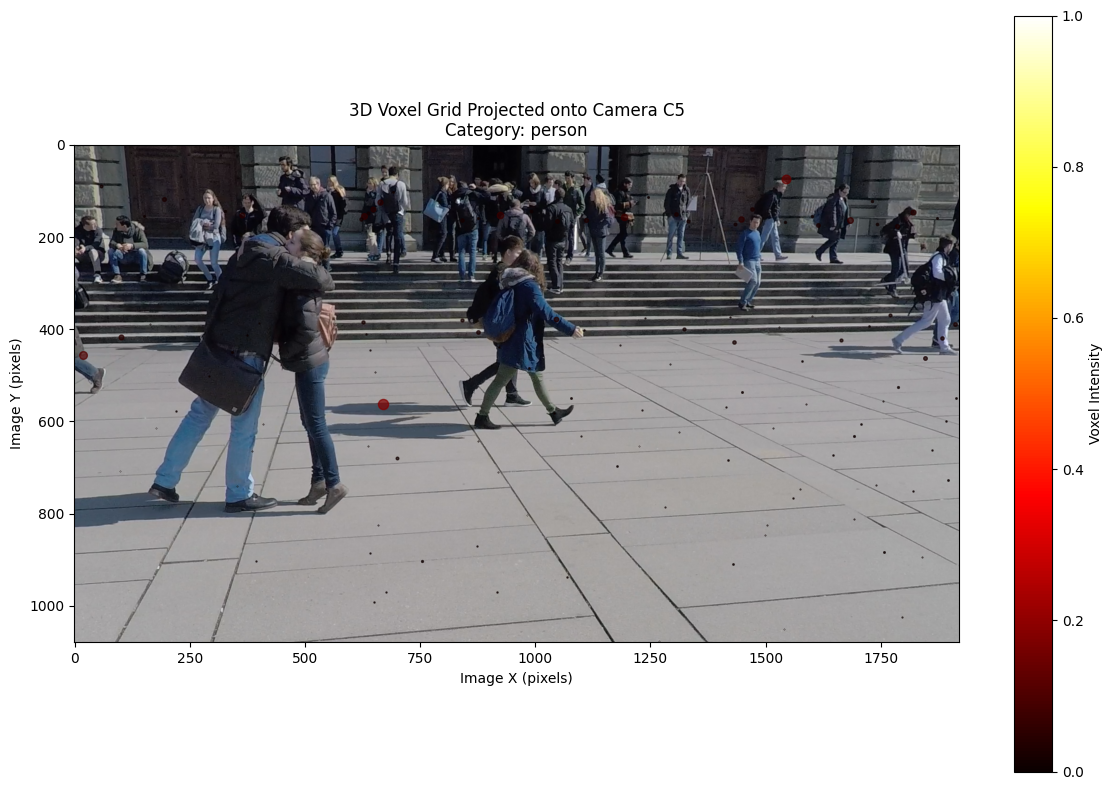

In [234]:
# visualize on camera plane
camera = "C5"
category_to_visualize = 'person'
voxel_threshold = 0
size_scale = 300

## Code
voxel_data = voxel_arrays[category_to_visualize] / np.max(voxel_arrays[category_to_visualize])
voxel_points = np.array(
    list(np.ndindex(voxel_data.shape))
) * spacing + np.array([xrange[0], yrange[0], zrange[0]])
image_positions = world_points_to_image_points(voxel_points, camera)

## Visualization
image_overlay = image_df[camera][0].copy()

# Get the voxel intensities (flattened to match voxel_points)
voxel_intensities = voxel_data.flatten()

# Filter out points outside the image boundaries and with low intensities
height, width = image_overlay.shape[:2]
valid_mask = (
    (image_positions[:, 0] >= 0) & 
    (image_positions[:, 0] < width) &
    (image_positions[:, 1] >= 0) & 
    (image_positions[:, 1] < height) &
    (voxel_intensities > voxel_threshold)  # Only show voxels with intensity > threshold
)

valid_positions = image_positions[valid_mask]
valid_intensities = voxel_intensities[valid_mask]

# Create a colormap overlay
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(
    cv.cvtColor(image_overlay, cv.COLOR_BGR2RGB)
)

# Scale point sizes by intensity (larger = higher intensity)
point_sizes = valid_intensities * size_scale  # Adjust multiplier to control max size

# Scale alpha by intensity too (more opaque = higher intensity)
point_alpha = 0.7  # Max alpha of 0.7 to keep image visible

# Plot the projected voxels with colors, sizes, and alphas based on intensity
for i in range(len(valid_positions)):
    ax.scatter(
        valid_positions[i, 0], 
        valid_positions[i, 1],
        c=[valid_intensities[i]],
        cmap='hot',
        alpha=point_alpha,
        s=point_sizes[i],
        vmin=0,
        vmax=1
    )

# Create a dummy scatter for the colorbar
scatter = ax.scatter(
    [], [],
    c=[],
    cmap='hot',
    vmin=0,
    vmax=1
)

plt.colorbar(scatter, ax=ax, label='Voxel Intensity')
ax.set_title(f'3D Voxel Grid Projected onto Camera {camera}\nCategory: {category_to_visualize}')
ax.set_xlabel('Image X (pixels)')
ax.set_ylabel('Image Y (pixels)')
plt.tight_layout()
plt.show()